## Building database
I have 6 SS WPS2 genomes, so I'll concatenate sequences into a single combined fasta file

## Version 1.3:
- Functional programming
- Combined assembled and unassembled

In [22]:
from Bio import SeqIO
import time
import os
import shutil
import pandas

In [103]:
#parameters
version = 'v1.4'
project_name = 'wps2_bl_metagenome'
e_value = 1e-20
iden = 95.0
metric = 50.0

In [2]:
!cat ../ss_genomes/AP_WPS-2_bacterium* > ../ss_genomes/all_AP_WPS-2_bacterium.fna

In [3]:
!makeblastdb -in ../ss_genomes/all_AP_WPS-2_bacterium.fna -dbtype nucl -title "combined_ss_WPS2" -out ../blast_db/combined_ss_WPS2/combined_ss_WPS2 -parse_seqids



Building a new DB, current time: 11/13/2016 23:46:34
New DB name:   ../blast_db/combined_ss_WPS2/combined_ss_WPS2
New DB title:  combined_ss_WPS2
Sequence type: Nucleotide
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 665 sequences in 0.0848749 seconds.


### OK - verified

# Running Blast query

In [3]:
import time
start =time.time()
!blastp -db test_pp_pmo -query 76969.assembled.faa -out assembl_contigs_vs_test_pp_pmo2.tab -evalue .00001 -outfmt 6 -num_threads 8
print "command was executed in %d seconds"%(time.time()-start)

^C


## Optimizing number of threads - No real difference

In [1]:

ex_time=list()
num_thread=list()
for i in [1,2,4,6,8]:
    start =time.time()
    !blastp -db test_pp_pmo -query 76969.assembled.faa -out assembl_contigs_vs_test_pp_pmo2.tab -evalue .00001 -outfmt 6 -num_threads {i}
    elapsed=time.time()-start
    print 'number of threads: ', i
    print 'exec time: ', elapsed
    ex_time.append(elapsed)
    num_thread.append(i)

number of threads:  1
exec time:  2587.95323396
number of threads:  2
exec time:  2689.65229201
number of threads:  4
exec time:  2710.735955
number of threads:  6
exec time:  2715.41233706
number of threads:  8
exec time:  2493.76898289


# Defining functions

In [126]:

def parse_contigs_ind(f_name):
    """
    Returns sequences index from the input files(s)
    remember to close index object after use
    """
    handle = open(f_name, "rU")
    record_dict = SeqIO.index(f_name,"fasta")
    handle.close()
    return record_dict

#returning specific sequences and overal list
def retrive_sequence(contig_lst, rec_dic):
    """
    Returns list of sequence elements from dictionary/index of SeqIO objects specific to the contig_lst parameter
    """
    contig_seqs = list()
    #record_dict = rec_dic
    #handle.close()
    for contig in contig_lst:
        contig_seqs.append(rec_dic[contig].seq.tostring())
    return contig_seqs


def filter_seq_dict(key_lst, rec_dic):
    """
    Returns filtered dictionary element from rec_dic according to sequence names passed in key_lst
    """
    return { key: rec_dic[key] for key in key_lst }

def unique_scaffold_topEval(dataframe):
#returns pandas series object
    variables = list(dataframe.columns.values)
    scaffolds=dict()
    rows=list()

    for row in dataframe.itertuples():
        
        #if row[1]=='Ga0073928_10002560':
        if row[1] not in scaffolds:
            scaffolds[row[1]]=row
        else:
            if row[11]<scaffolds[row[1]][11]:
                scaffolds[row[1]]=row
    rows=scaffolds.values()
    #variables=['quid', 'suid', 'iden', 'alen', 'mism', 'gapo', 'qsta', 'qend', 'ssta', 'send', 'eval', 'bits']
    df = pandas.DataFrame([[getattr(i,j) for j in variables] for i in rows], columns = variables)
    return df

# Making all_WPS-2 Database [ln3] again more scalable way

In [3]:
iteration = 0

In [2]:
blast_db_homeDir = "../blast_db/"

In [3]:
#!mkdir blast_db_homeDir

## Reading Raw input file and creating specific input file

In [21]:
#command_line file of reference sequences
reference_0 = "../ss_genomes/all_AP_WPS-2_bacterium.fna"

input_dir = "input_files"
if os.path.exists(input_dir):
    shutil.rmtree(input_dir)
try:
    os.mkdir(input_dir)
except OSError:
    raise
#returns 
records_0 = parse_contigs_ind(reference_0)
ref_out_0 = "input_files/reference0.fna"
with open(ref_out_0, "w") as handle:
    SeqIO.write(records_0.values(), handle, "fasta")
    #NO NEED TO CLOSE with statement will automatically close the file
records_0.close()

# After iteration0 is done:
* filter assembled e-20: >=95 iden, >=50 metric
* add records to output_1

In [66]:
output_1 = "../ss_genomes/iteration1.fna"

In [83]:
iteration1_all =cutoff_contigs['1e-20_cutoff_contigs']
print len(iteration1_all) 
len((iteration1_all[iteration1_all['iden']>=95.0]))
print len((iteration1_all[iteration1_all['iden']>=95.0]))
print len((iteration1_all[iteration1_all['Metric']>=50]))

9594
2085
5658


In [89]:
iteration1_filtered = iteration1_all[(iteration1_all['iden']>=95.0)&(iteration1_all['Metric']>=50)]
len(iteration1_filtered)

1828

In [101]:
names = iteration1_filtered['quid'].tolist()

In [130]:
records_0 = dict(parse_contigs_ind(input_0))
#all_records = parse_contigs_ind(assembled_contigs)
records_1 = filter_seq_dict(names, all_records)
print type(records_1)
records_1.update(records_0)

<type 'dict'>


In [131]:
len(records_0.items())

665

In [132]:
len(records_1.items())

2493

# Outputting iteration 1

In [133]:
#records_0 = parse_contigs_ind(input_0)
output_1_0 = "../ss_genomes/iteration1_0.fna"
output_1 = "../ss_genomes/iteration1_0.fna"
with open(output_1_0, "w") as handle:
  SeqIO.write(records_0.values(), handle, "fasta")
with open(output_1, "w") as handle:
  SeqIO.write(records_1.values(), handle, "fasta")

## Repeating what we've done

In [110]:
type(records_1)


# output_0 = "../ss_genomes/iteration0.fna"
# with open(output_0, "w") as handle:
#   SeqIO.write(records_0.values(), handle, "fasta")

dict

In [105]:
len(records_0)

665

## adding those to the database 

In [80]:
(iteration1_all[iteration1_all['iden']>=95.0])&(iteration1_all[iteration1_all['alen']>=50])

TypeError: unsupported operand type(s) for &: 'str' and 'str'

In [10]:
dct1

{'a': 2, 'b': 3, 'c': 5, 'd': 1}

In [5]:
in_db = '../ss_genomes/all_AP_WPS-2_bacterium.fna'
title = 'combined_ss_WPS2'
outfile = "../blast_db/combined_ss_WPS2/combined_ss_WPS2"

!makeblastdb -in {infile} -dbtype nucl -title "{title}" -out {outfile} -parse_seqids



Building a new DB, current time: 11/13/2016 23:59:45
New DB name:   ../blast_db/combined_ss_WPS2/combined_ss_WPS2
New DB title:  combined_ss_WPS2
Sequence type: Nucleotide
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 665 sequences in 0.0594308 seconds.


## Blasting assembled and unasembled contigs

In [24]:
import time
q_fname1 = './../IMG Data/76969.assembled.fna'
q_fname2 = './../IMG Data/76969.unassembled_illumina.fna'
out_name1= 'all_wps2_q_assembled76969.tab'
out_name2= 'all_wps2_q_unasembled76969.tab'
database = '../blast_db/combined_ss_WPS2/combined_ss_WPS2'
# start =time.time()
# !blastn -db {database} -query "{q_fname1}" -out {out_name1} -evalue .00001 -outfmt 6 -num_threads 8
# elapsed=time.time()-start
# print 'exec time: ', elapsed
# start =time.time()
# !blastn -db {database} -query "{q_fname2}" -out {out_name2} -evalue .00001 -outfmt 6 -num_threads 8
# elapsed=time.time()-start
# print 'exec time: ', elapsed


# Parsing Blast Outputs

## Trying pandas instead

In [127]:
del recruited_mg

In [128]:
recruited_mg_1 = pandas.read_csv(out_name1 ,sep="\t", header=None)
recruited_mg_1.columns=['quid', 'suid', 'iden', 'alen', 'mism', 'gapo', 'qsta', 'qend', 'ssta', 'send', 'eval', 'bits']

recruited_mg_2 = pandas.read_csv(out_name2 ,sep="\t", header=None)
recruited_mg_2.columns=['quid', 'suid', 'iden', 'alen', 'mism', 'gapo', 'qsta', 'qend', 'ssta', 'send', 'eval', 'bits']

recruited_mg = [recruited_mg_1, recruited_mg_2]

In [129]:
len(recruited_mg[0])

26364

In [130]:
len(recruited_mg[1])

12145

# Adding "Metric", "Seq_size", "Seq_nt" fields
## indeces of metagenome sequences and the recruited from blast dataframe are placed in lists of the same size: No of -m (metagenome) sequences

In [100]:
#For linux use symlink
metagenome_1 ="../../pp_metagenome1/IMG Data/76969.assembled.fna"
metagenome_2 ="../../pp_metagenome1/IMG Data/76969.unassembled_illumina.fna"
#!Beware of closing all records enries eventually
all_records_mg_1=parse_contigs_ind(metagenome_1)
all_records_mg_2=parse_contigs_ind(metagenome_2)
all_records=[all_records_mg_1, all_records_mg_2]

In [131]:





start = time.time()
#wps2_eval_cutoff['Seq_nt']=retrive_sequence(contig_list, all_records)
for i in range(len(recruited_mg)):
    #cutoff_contigs[dataframe]=evalue_filter(cutoff_contigs[dataframe])
    recruited_mg[i]=unique_scaffold_topEval(recruited_mg[i])
    contig_list = recruited_mg[i]['quid'].tolist()
    recruited_mg[i]['Seq_nt']=retrive_sequence(contig_list, all_records[i])
    recruited_mg[i]['Seq_size']=recruited_mg[i]['Seq_nt'].apply(lambda x: len(x))
    recruited_mg[i]['Coverage']=recruited_mg[i]['alen'].apply(lambda x: float(x))/recruited_mg[i]['Seq_size']
    recruited_mg[i]['Metric']=recruited_mg[i]['Coverage']*recruited_mg[i]['iden']
    recruited_mg[i] = recruited_mg[i][['quid', 'suid', 'iden', 'alen','Coverage','Metric', 'mism', 'gapo', 'qsta', 'qend', 'ssta', 'send', 'eval', 'bits','Seq_size', 'Seq_nt']]
    #all_records[i].close()# keep open if multiple iterations

    
elapsed=time.time()-start
print elapsed


1.90100002289


In [91]:
# don't close just yet
# do after it is not needed
for i in range(len(recruited_mg)):
    all_records[i].close()

In [132]:
print  len(recruited_mg[0])
print len(recruited_mg[1])

11345
6297


## Number of unique scaffolds found

In [133]:
len(set(recruited_mg[0]['quid']))

11345

In [134]:
len(set(recruited_mg[1]['quid']))

6297

## Evalue sorting

In [40]:
#result = df.sort(['A', 'B'], ascending=[1, 0])\

# wps2_assembled_sort_eval = wps2_assembled.sort_values(by=['eval'], ascending=False)
# wps2_assembled_sort_eval

## Filtering out by evalue cutoff

In [25]:
# eval_cutoff = 1e-20
# wps2_assembled_filtered = wps2_assembled_sort_eval[wps2_assembled_sort_eval['eval']<eval_cutoff]
# wps2_assembled_filtered

## Efect of evalue on # of unique scaffolds found

In [26]:
# #Doing a 
# unique_scaffolds = list()
# eval_cutoffs = [1e-10, 1e-20, 1e-30, 1e-40, 1e-50, 1e-60, 1e-70, 1e-80, 1e-90, 1e-100, 1e-110, 1e-120, 1e-130, 1e-140, 1e-150]
# #for e_val in eval_cutoffs:
# for e_val in eval_cutoffs:
#     wps2_assembled_filtered = wps2_assembled_sort_eval[wps2_assembled_sort_eval['eval']<e_val]
#     unique_scaffolds.append(len(set(wps2_assembled_filtered['quid'])))


In [27]:
# print eval_cutoffs
# print unique_scaffolds


In [28]:
# import matplotlib
# import matplotlib.pyplot as plt
# %matplotlib inline  
# #plt.semilogy(t, np.exp(-t/5.0))
# plt.plot()
# plt.semilogx(eval_cutoffs, unique_scaffolds, marker = 'o', basex=10)
# plt.title('Number of unique scaffolds as a function of BLAST e-Value')
# plt.xticks(eval_cutoffs)
# plt.ylabel('No. of unique scaffolds')
# plt.xlabel('BLAST e-Value')
# plt.grid(True)
# plt.ylim((0,12000))
# plt.show()

# Doing some stats on the recruited data

In [41]:

#assembled

ranges = range(5, 210, 15)
unique_scaffolds = list()
eval_ranges = [10**(-x) for x in ranges]
assembled_filtered_lst = list()
#for e_val in eval_cutoffs:
for i in range(len(eval_ranges)):
    assembled_filtered = recruited_mg[0][recruited_mg[0]['eval']<eval_ranges[i]]
    assembled_filtered_lst.append(assembled_filtered)
    #unique_scaffolds.append(len(set(wps2_assembled_filtered['quid'])))
    unique_scaffolds.append(len(set(assembled_filtered_lst[i]['quid'])))

In [42]:
print ranges
print eval_ranges
print unique_scaffolds

[5, 20, 35, 50, 65, 80, 95, 110, 125, 140, 155, 170, 185, 200]
[1e-05, 1e-20, 1e-35, 1e-50, 1e-65, 1e-80, 1e-95, 1e-110, 1e-125, 1e-140, 1e-155, 1e-170, 1e-185, 1e-200]
[11341, 9594, 8348, 7455, 6718, 6131, 5669, 5281, 4927, 4592, 4236, 3938, 3724, 3724]


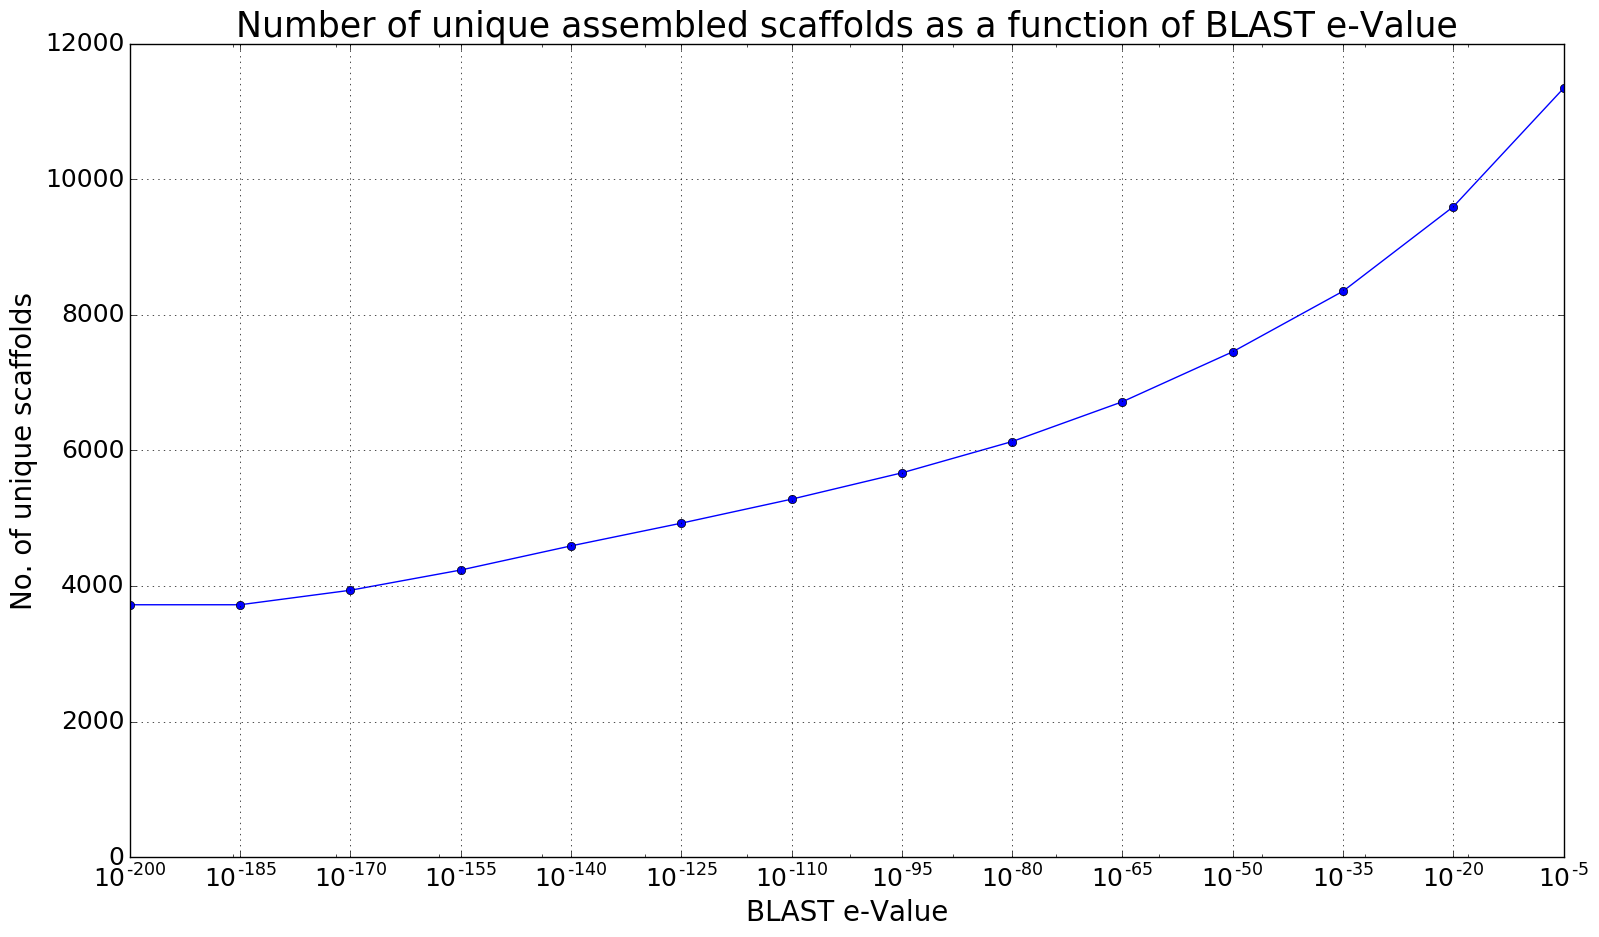

In [43]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

#plt.semilogy(t, np.exp(-t/5.0))
plt.plot()
plt.semilogx(eval_ranges, unique_scaffolds, marker = 'o', basex=10)
plt.title('Number of unique assembled scaffolds as a function of BLAST e-Value', fontsize=25)
plt.xticks(eval_ranges, fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('No. of unique scaffolds', fontsize=20)
plt.xlabel('BLAST e-Value', fontsize=20)
plt.grid(True)
plt.ylim((0,12000))
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('assembled_fn_evalue.pdf', dpi=300)
plt.show()

## Retrieving sequences from dataframe list

In [44]:
# dataframe_names= [str(x)+"_cutoff_contigs" for x in eval_ranges]
# dataframe_names

In [33]:
# # cutoff = eval_ranges[3]
# # cutoff_contigs = wps2_assembled_filtered_lst[3]
# cutoff_contigs={}
# # #cutoff_contigs
# for i in range(len(eval_ranges)):
#     cutoff_contigs[dataframe_names[i]]=wps2_assembled_filtered_lst[i]

In [34]:
len(cutoff_contigs['1e-50_cutoff_contigs'])

15813

In [35]:
print list(cutoff_contigs['1e-50_cutoff_contigs'].columns.values)

['quid', 'suid', 'iden', 'alen', 'mism', 'gapo', 'qsta', 'qend', 'ssta', 'send', 'eval', 'bits']


## Adding Seq_nt and Size entries

In [45]:

# from Bio import SeqIO
# assembled_contigs = "../IMG Data/76969.assembled.fna"
# handle = open(assembled_contigs, "rU")
# record_dict = SeqIO.to_dict(SeqIO.parse(handle,"fasta"))
# handle.close()
# rec = record_dict["Ga0073928_11111377"]
# rec

## Indexing approach
# Less memory intensive, close index after it's done: record_dict.close()


In [47]:
# start = time.time()
# all_records = parse_contigs_ind(assembled_contigs)
# print time.time()-start


In [48]:
# all_records.close()

In [50]:
# all_records['Ga0073928_10022750']

In [49]:
# all_records=parse_contigs_ind(assembled_contigs)
# start = time.time()
# #wps2_eval_cutoff['Seq_nt']=retrive_sequence(contig_list, all_records)
# for dataframe in cutoff_contigs:
#     #cutoff_contigs[dataframe]=evalue_filter(cutoff_contigs[dataframe])
#     contig_list = cutoff_contigs[dataframe]['quid'].tolist()
#     cutoff_contigs[dataframe]['Seq_nt']=retrive_sequence(contig_list, all_records)
#     cutoff_contigs[dataframe]['Seq_size']=cutoff_contigs[dataframe]['Seq_nt'].apply(lambda x: len(x))
#     cutoff_contigs[dataframe]['Coverage']=cutoff_contigs[dataframe]['alen'].apply(lambda x: float(x))/cutoff_contigs[dataframe]['Seq_size']
#     cutoff_contigs[dataframe]['Metric']=cutoff_contigs[dataframe]['Coverage']*cutoff_contigs[dataframe]['iden']
#     cutoff_contigs[dataframe] = cutoff_contigs[dataframe][['quid', 'suid', 'iden', 'alen','Coverage','Metric', 'mism', 'gapo', 'qsta', 'qend', 'ssta', 'send', 'eval', 'bits','Seq_size', 'Seq_nt']]
# elapsed=time.time()-start
# print elapsed
# all_records.close()

In [51]:
# cutoff_contigs['1e-50_cutoff_contigs']

In [52]:
# cutoff_contigs['1e-50_cutoff_contigs'].loc[7444]['Seq_nt']

In [53]:
# !cutoff_contigs['1e-50_cutoff_contigs'].loc[7444]['Seq_nt'][:30] "../IMG Data/76969.assembled.fna"

In [54]:
# #verification by manual searching and extracting the sequence
# len(''.join("""CCTGTTAGTGCTTCGGCGCCCGATACAATCTCGAGCAGCTCCTTGGTTATCGCGGCTTGA
# CGCGCGTTGTTCATAGCGATCGTCAGTTCATCGATCAATTTGCCGGCGTTTTCGGTGGCG
# TTGTTCATTGCAAGCAGCTGAGCTGCGTAGAATGACGCATCGGTCTCCAGCATCGCCGAA
# AATAGTGTGAACTCCAGATATTTCGGCAAGAGTTTTGAAAGTACGAACTCCGGCGAAGGC
# ACGATTTCGACCGCGCCGCGCGGACCCGTGGATGGAGCCGCCGCGGTTTCATGCTCGATC
# GGGACAAGCTGCCGTAGCTCGGGTCGCTGCACCATCATCGAGACATGTTTGGACGAAACG
# AGGATGATGTCGCCGATCTCTCCGGCGGTGAAATCGGCGGTGACGCTCTGCGCGAGTTCG
# TGCGCGGTTTGCAGTTTGGACGGCGCACTCAGCGGCCAGCCCGGCCGATCTCCTAGGCCC
# CAGCGGCGCACAGCGTTGCGAGCTTTTATGCCGACGGTGTAAAAACGCGCGTCCGCGTGC
# TGACGCCAGAAGCGCTCGGCCTCGCGAATGACGTTGGAGTTGAATGCGCCGGCCAG""".split()))

In [55]:
# len(cutoff_contigs['1e-50_cutoff_contigs'].loc[7444]['Seq_nt'])

In [125]:
recruited_mg[0]

,quid,suid,iden,alen,Coverage,Metric,mism,gapo,qsta,qend,ssta,send,eval,bits,Seq_size,Seq_nt
0,Ga0073928_10000001,2616646159,73.97,438,0.000371,0.027420,100,13,725591,726021,10816,11246,1.000000e-37,165.0,1181591,ACAGTACCTTCGTGATCGCCGCAGTCAGCGTCGTCTTGCCGTGGTC...
1,Ga0073928_10000002,2616653076,74.33,1005,0.001313,0.097569,233,23,110425,111418,475,1465,1.000000e-109,403.0,765630,CCAGTTCAATCCCGGTGCCCATCTGCTGGGCCAGCGCTTCGGCTGC...
2,Ga0073928_10000002,2617273876,74.33,1005,0.001313,0.097569,233,23,110425,111418,34447,35437,1.000000e-109,403.0,765630,CCAGTTCAATCCCGGTGCCCATCTGCTGGGCCAGCGCTTCGGCTGC...
3,Ga0073928_10000003,2616646130,74.74,1607,0.002156,0.161123,376,29,217242,218833,2554,963,0.000000e+00,691.0,745438,GAAGGGCGGGTACCACGAACGTCTGCGCCTGCGACGCTACGCTACC...
4,Ga0073928_10000004,2616646178,88.33,60,0.000083,0.007306,7,0,56696,56755,3397,3456,4.000000e-10,73.1,725374,CGGATTGTGTTTCGACAACACCTTGGTGATGGCCGCCGTCAACGTG...
5,Ga0073928_10000004,2616653415,92.86,42,0.000058,0.005377,3,0,231872,231913,1625,1666,9.000000e-07,62.1,725374,CGGATTGTGTTTCGACAACACCTTGGTGATGGCCGCCGTCAACGTG...
6,Ga0073928_10000005,2616646216,79.71,971,0.001377,0.109752,191,5,102846,103813,6097,7064,0.000000e+00,697.0,705209,CATCTCCAACCCCCACGCCGAGCGCAACGTCATCGCCTACGCCAAC...
7,Ga0073928_10000005,2616646158,79.20,971,0.001377,0.109050,180,16,102846,103805,4551,3592,0.000000e+00,654.0,705209,CATCTCCAACCCCCACGCCGAGCGCAACGTCATCGCCTACGCCAAC...
8,Ga0073928_10000005,2616653440,73.68,1083,0.001536,0.113151,249,33,615295,616359,5839,6903,3.000000e-105,388.0,705209,CATCTCCAACCCCCACGCCGAGCGCAACGTCATCGCCTACGCCAAC...
9,Ga0073928_10000005,2616646201,74.32,767,0.001088,0.080832,163,29,474629,475375,15357,14605,8.000000e-77,294.0,705209,CATCTCCAACCCCCACGCCGAGCGCAACGTCATCGCCTACGCCAAC...


In [56]:
# wps2_eval_cutoff['Seq_size']=wps2_eval_cutoff['Seq_nt'].apply(lambda x: len(x))
# wps2_eval_cutoff = wps2_eval_cutoff[['quid', 'suid', 'iden', 'alen', 'mism', 'gapo', 'qsta', 'qend', 'ssta', 'send', 'eval', 'bits','Seq_size', 'Seq_nt']]
# wps2_eval_cutoff

# Filtering Step

In [136]:
for i in range(len(recruited_mg)):
    recruited_mg[i]=recruited_mg[i][(recruited_mg[i]['iden']>=iden)&(recruited_mg[i]['Metric']>=metric)&(recruited_mg[i]['eval']<=e_value)]


In [144]:
print  len(recruited_mg[0])
print len(recruited_mg[1])

1955
2637


## Batch export to csv and multiple FASTA

In [152]:
#wps2_eval_cutoff.to_csv(path_or_buf="wps2_eval_cutoff.csv", sep='\t')
prefix="iteration1_"+str(version)+"_"+str(e_value)+"_recruited_mg"
for i in range(len(recruited_mg)):
    records= []
    outfile1 = prefix+str(i)+".csv"
#     try:
#         os.remove(outfile1)     
#     except OSError:
#         pass
    recruited_mg[i].to_csv(outfile1, sep='\t')
    ids = recruited_mg[i]['quid'].tolist()
    #if len(ids)==len(sequences):
    for j in range(len(ids)):
        records.append(all_records[i][ids[j]])
    outfile2 = prefix+str(i)+".fasta" 
#     try:
#         os.remove(outfile2)        
#     except OSError:
#         pass
    with open(outfile2, "w") as output_handle:
        SeqIO.write(records, output_handle, "fasta")
        

    #print prefix+dataframe_name    